In [1]:
from pyprojroot import here

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle 

import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as vis_transforms

import searchnets
from searchnets import transforms
from searchnets.datasets import VOCDetection

In [2]:
def cm_to_inches(cm):
    return cm / 2.54

In [3]:
VSD_DATASET_SPLIT_CSV = here().joinpath('data/Visual_Search_Difficulty_v1.0/VSD_dataset_split.csv')

VSD_FOR_VISUALIZE_CSV = here().joinpath('data/Visual_Search_Difficulty_v1.0/VSD_dataset_for_visualizing.csv')

#### make csv used just to visualize dataset from "split" csv created by searchnets.data

In [4]:
remake_csv_for_visualize = False

if remake_csv_for_visualize:
    vsd_df = pd.read_csv(VSD_DATASET_SPLIT_CSV)
    vsd_df['split'] = 'train'  # set 'split' to 'train' for all rows so we can get all of dataset from one dataloader
    vsd_df = vsd_df.sort_values(by='difficulty_score')

    vsd_df.to_csv(VSD_FOR_VISUALIZE_CSV)

else:
    vsd_df = pd.read_csv(VSD_FOR_VISUALIZE_CSV)

#### set up so we can grab images from dataset for figure

In [5]:
ROOT = '/home/bart/Documents/data/voc/'
PAD_SIZE = searchnets.transforms.functional.VSD_PAD_SIZE

transform = vis_transforms.Compose(
    [vis_transforms.ToTensor(),
     transforms.RandomPad(pad_size=PAD_SIZE),
     ]
)


target_transform = vis_transforms.Compose([
    transforms.ParseVocXml(),
    transforms.ClassIntsFromXml(),
    transforms.OneHotFromClassInts(),
])

trainset = VOCDetection(root=ROOT,
                        csv_file=VSD_FOR_VISUALIZE_CSV,
                        image_set='trainval',
                        split='train',
                        download=True,
                        transform=transform,
                        target_transform=target_transform
                        )

BATCH_SIZE = 64
NUM_WORKERS = 32

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS,
                          pin_memory=True)

Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar


/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 24, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


get device for `torch`

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#### select images based on visual difficulty score

In [7]:
n_samples = len(vsd_df)
ind_25_pct = int(n_samples * 0.25)
ind_75_pct = int(n_samples * 0.75)

IMGS_TO_USE_FOR_VIS = [
    vsd_df['img'].values[0],
    vsd_df['img'].values[ind_25_pct],
    vsd_df['img'].values[ind_75_pct],
    vsd_df['img'].values[-1],
]

KEYS = ['img', 'name', 'vsd_score']

FOR_FIG = {}

n_items_all = []

for batch in train_loader:
    # get number of (annotated) items / objects in each image, to add to dataframe
    n_items_all.append(
        batch['target'].sum(dim=1).cpu().numpy()
    )

    # check if one of images for figure is in batch, if so add it to dictionary
    for ind, name in enumerate(batch['name']):
        if name in IMGS_TO_USE_FOR_VIS:
            FOR_FIG[name] = {
                'img': batch['img'][ind].cpu().numpy(),
                'vsd_score': batch['vsd_score'][ind].cpu().numpy(),
            }

In [8]:
vsd_df['n_items'] = np.concatenate(n_items_all).astype(int)

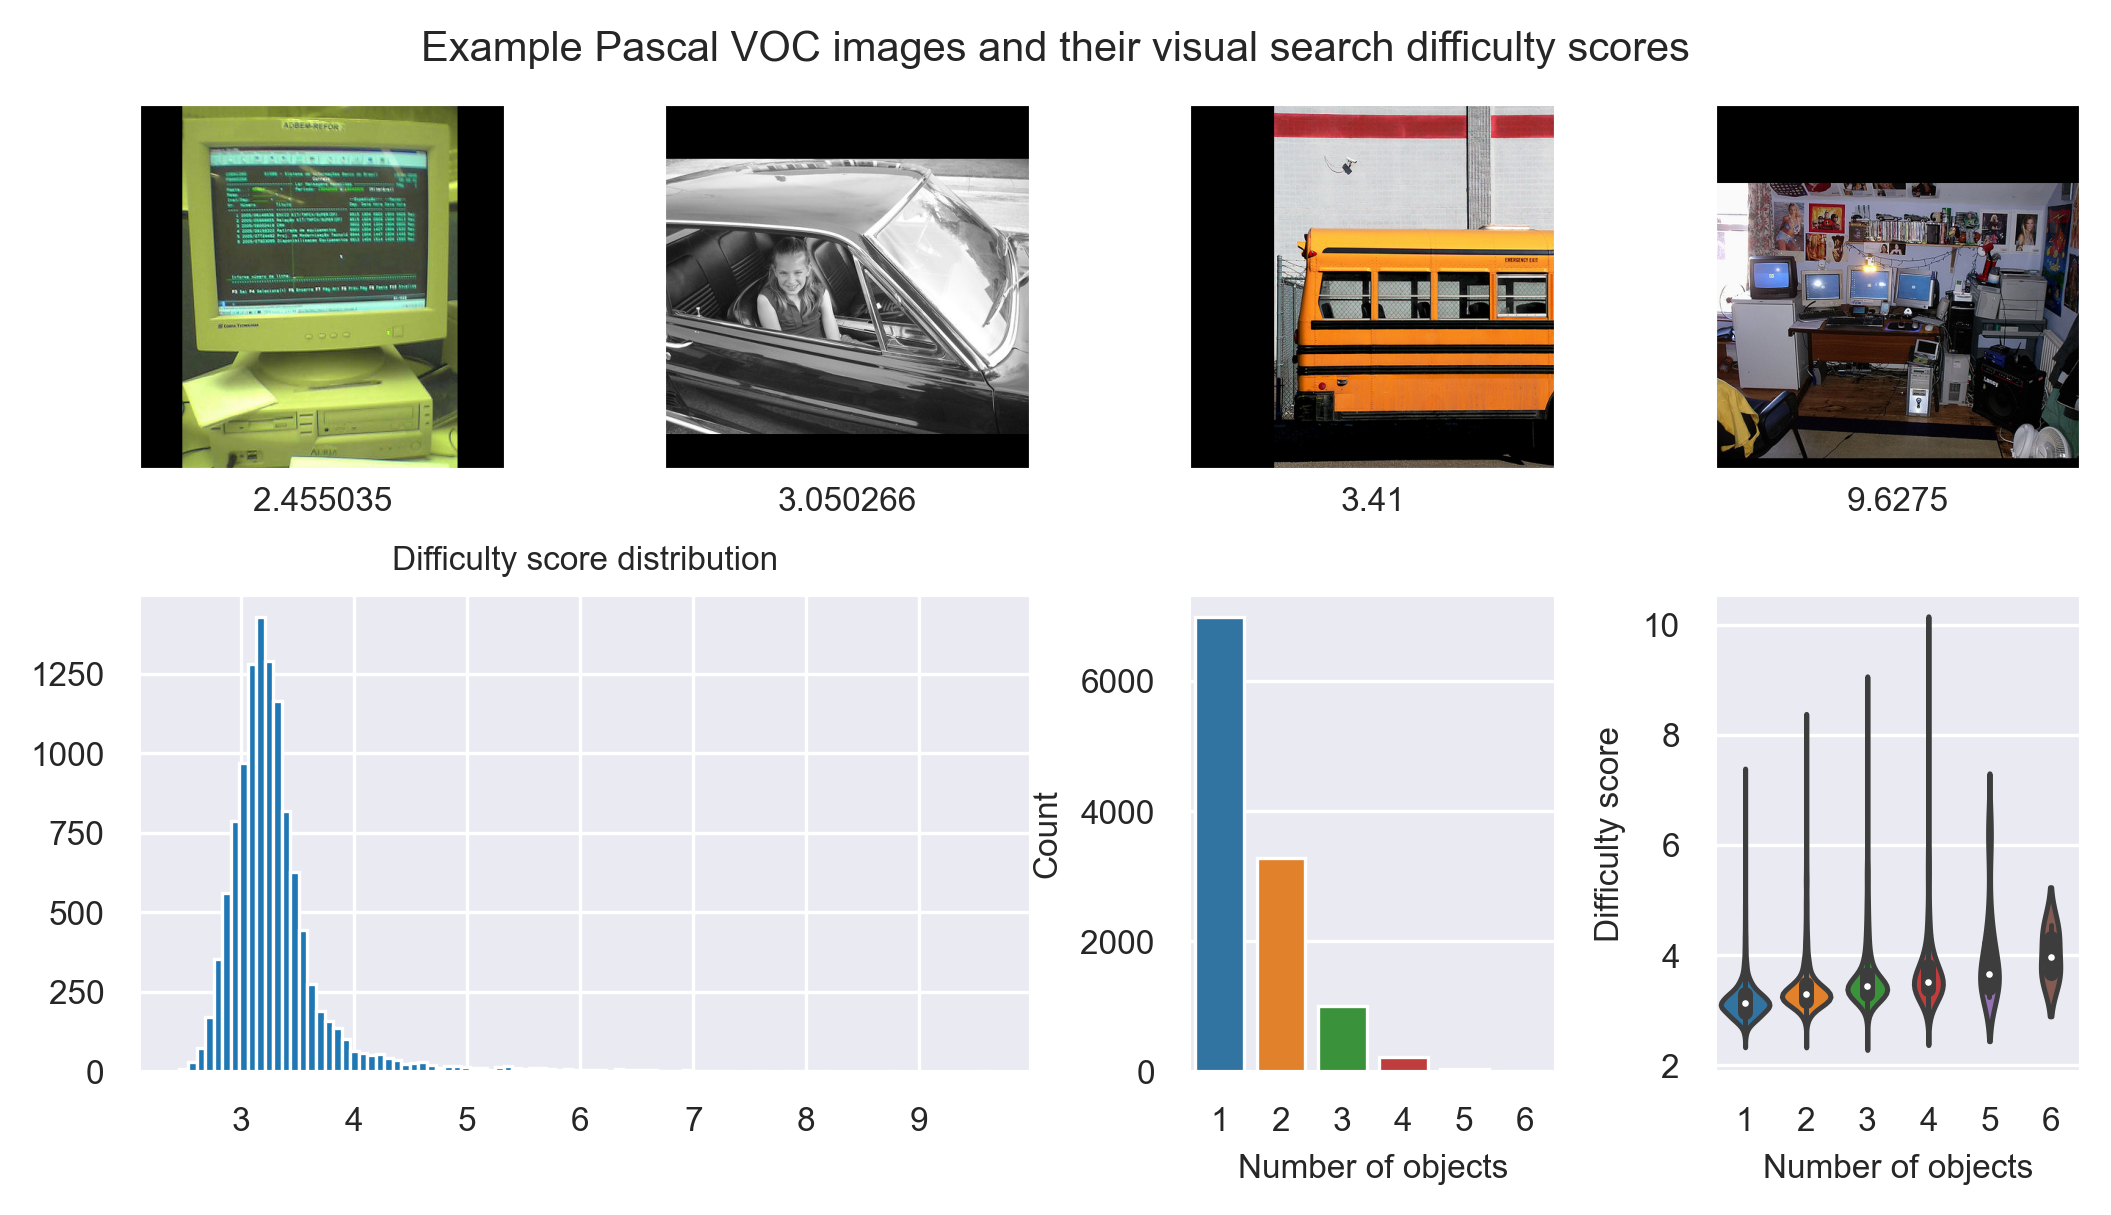

In [22]:
RC= {'axes.labelsize': 8,
     'axes.titlesize': 8,
     'xtick.labelsize': 8,
     'ytick.labelsize': 8,
     'legend.fontsize': 8,   
     }

sns.set_style("darkgrid")
sns.set_context("paper", rc=RC)

FIGSIZE = tuple(cm_to_inches(size) for size in (17.4, 10))
DPI = 300
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
gs = fig.add_gridspec(2, 4)

img_ax = [fig.add_subplot(gs[0, ind]) for ind in range(4)]
vsd_hist_ax = fig.add_subplot(gs[1,:2])
n_items_counts_ax = fig.add_subplot(gs[1,2])
items_diff_score_scatter_ax = fig.add_subplot(gs[1,3])

for ind, (name, img_dict) in enumerate(FOR_FIG.items()):
    img = img_dict['img']
    img = np.transpose(img, (1, 2, 0))
    img_ax[ind].set_xticks([])
    img_ax[ind].set_yticks([])
    img_ax[ind].imshow(img)
    img_ax[ind].set_xlabel(img_dict['vsd_score'])                 
    
vsd_hist_ax.hist(vsd_df['difficulty_score'], bins='scott')
vsd_hist_ax.set_title('Difficulty score distribution')

sns.countplot(x='n_items', data=vsd_df, 
              ax=n_items_counts_ax)
n_items_counts_ax.set_xlabel('Number of objects')
n_items_counts_ax.set_ylabel('Count')

sns.violinplot(x="n_items", y="difficulty_score", data=vsd_df, ax=items_diff_score_scatter_ax)
items_diff_score_scatter_ax.set_xlabel('Number of objects')
items_diff_score_scatter_ax.set_ylabel('Difficulty score')

fig.suptitle('Example Pascal VOC images and their visual search difficulty scores', fontsize=10)

fig.tight_layout(pad=0.05)

for ext in ('svg', 'png'):
    fig_path = here().joinpath(
        f'docs/paper/figures/experiment-2/VSD-dataset.{ext}'
    )
    plt.savefig(fig_path, bbox_inches='tight')